In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

In [3]:
#define model inputs
title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size,), name='text_body')
tags = keras.Input(shape=(num_tags,), name='tags')

In [4]:
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

In [5]:
#define model outputs
priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(num_departments, activation='softmax', name='department')(features)

In [6]:
model = keras.Model(inputs=[title, text_body, tags],
                    outputs=[priority, department])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',          

In [8]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

In [9]:
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [10]:
model.compile(optimizer='rmsprop', 
              loss=['mean_squared_error', 'categorical_crossentropy'], 
              metrics = [['mean_absolute_error'], ['accuracy']])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

2024-01-01 17:35:25.229206: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


40/40 [==============================] - 1s 5ms/step - loss: 32.9813 - priority_loss: 0.3238 - department_loss: 32.6575 - priority_mean_absolute_error: 0.4906 - department_accuracy: 0.3023


In [11]:
model.evaluate([title_data, text_body_data, tags_data],
                [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, 
                                                  text_body_data, 
                                                  tags_data])

40/40 [==============================] - 0s 2ms/step


In [12]:
model.compile(optimizer='rmsprop',
              loss={'priority':'mean_squared_error',
                    'department':'categorical_crossentropy'},
              metrics={'priority': ['mean_absolute_error'], 
                       'department':['accuracy']})
model.fit({"title": title_data, "text_body": text_body_data,
           "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data,
                "tags": tags_data},
{"priority": priority_data, "department": department_data}) 

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 2ms/step


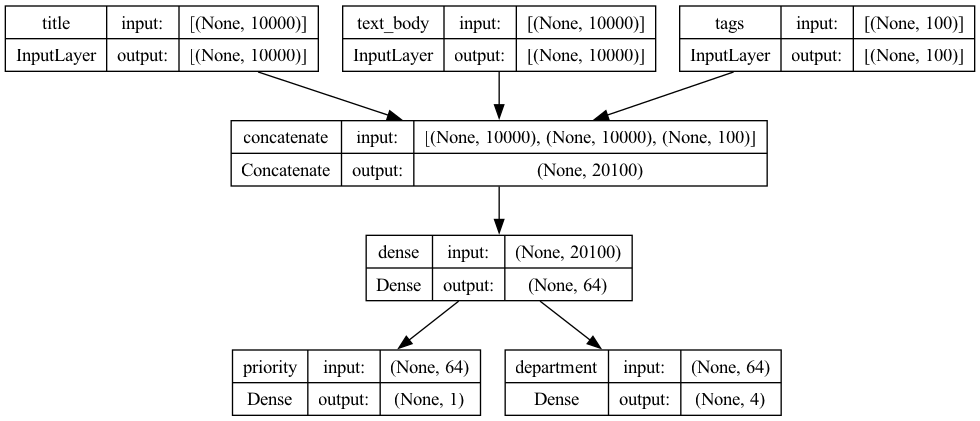

In [14]:
keras.utils.plot_model(
    model, "ticket_classifier_with_shape_info.png", show_shapes=True)

In [15]:
model.layers

In [16]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [17]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

In [18]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation='softmax',
                          name='difficulty')(features)

In [19]:
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department,difficulty])

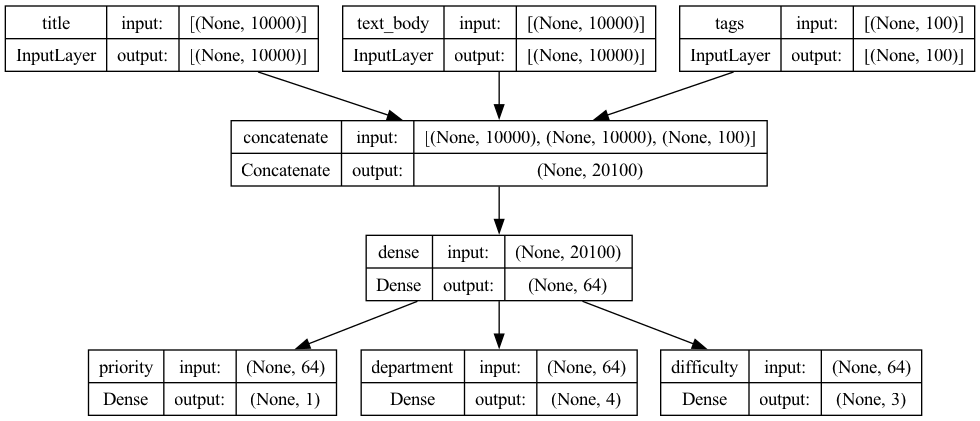

In [20]:
keras.utils.plot_model(new_model, 
                      'updated_ticket_classifier.png',
                      show_shapes=True)

In [21]:
class CustomerTicketModel(keras.Model):
    
    def __init__(self, num_departments):
        super().__init__()
        #define sublayers in the constructor
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(num_departments, 
                                                  activation='softmax')
    def call(self, inputs):
        #define the forward pass in the call() method
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']
        
        features = self.concat_layer([title, 
                                      text_body, tags])
        features = self.mixing_layer(features)
        
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        
        return priority, department
        

In [23]:
model = CustomerTicketModel(num_departments=4)
priority, department = model({'title': title_data, 
                             'text_body': text_body_data,
                             'tags': tags_data})

In [24]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"], 
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data, "text_body": text_body_data,
           "tags": tags_data}, 
          [priority_data, department_data], epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data,
                "tags": tags_data}, 
               [priority_data, department_data])
priority_preds, department_preds = model.predict({
                'title': title_data,
                'text_body': text_body_data,
                'tags': tags_data
})

40/40 [==============================] - 0s 2ms/step


In [27]:
class Classifier(keras.Model):
    
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)
    
    def call(self, inputs):
        return self.dense(inputs)
    

In [28]:
inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [29]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

In [32]:
class MyModel(keras.Model):
    
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier
        
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)
    
model = MyModel()